# Visualización del proceso de aprendizaje en Regresión Logística 2D con descenso de gradiente

Funciones auxiliares (solo ejecutar, y seguir más abajo)

In [1]:
%matplotlib notebook
import rnutil
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import matplotlib.patches as patches
from collections import namedtuple
from matplotlib import cm

PlotState = namedtuple('PlotState', ['figure','axes','legends'])
OptimalModel = namedtuple('Model', ['w', 'b','error'])

def optimal_model(x,y):
    from sklearn import datasets, linear_model
    regr = linear_model.LogisticRegression(C=1)
    regr.fit(x,y)
    optimal_w=regr.coef_[0]
    optimal_b=regr.intercept_[0]
    optimal_error=evaluate_model(x,y,optimal_w,optimal_b)
    return OptimalModel(optimal_w,optimal_b,optimal_error)



def sigmoid(x):
    return 1/(1+np.exp(-x))
def linear(x,w,b):
    return x.dot(w)+b

def predict(x,w,b):
    return sigmoid(linear(x,w,b))

def binary_cross_entropy(y,yhat):
    eps = np.finfo(float).eps
    n=len(y)
    errors=np.zeros(n)
    for i in range(n):
        if y[i]==1:
            errors[i]=-np.log(yhat[i]+eps)
        else: #y[i]==0
            errors[i]=-np.log(1-yhat[i]+eps)
            
    # implementación vectorial
    #errors=y* (-log(yhat)) +(1-y)* (-log(-yhat))
    return errors.sum()
    

def gradient(x,y,w,b):
    dEdw=np.zeros_like(w)
    dEdb=0
    n=len(x)
    fx=predict(x,w,b)
    for i in range(n):
        dEdwi=(fx[i]-y[i])*x[i,:]
        dEdw+=dEdwi
        dEdbi=(fx[i]-y[i])
        dEdb+=dEdbi
    dEdwi=dEdwi/n
    dEdb=dEdb/n
    return dEdw,dEdb

def visualizar_modelo(ax_data,x,w,b):
    samples=100
    xmin,xmax=x.min(),x.max()
    param_range=max(abs(xmin),abs(xmax))+5
    X = np.linspace(-param_range, param_range, samples)
    Y = np.linspace(-param_range, param_range, samples)    
    xx, yy = np.meshgrid(X, Y)
    pp=np.zeros_like(xx)
    ss=np.zeros_like(xx)
    n,m=len(X),len(Y)
    for i in range(n):
        for j in range(m):
            plot_x=np.array([xx[i,j],yy[i,j]])
            pp[i,j]=predict(plot_x,w,b)
            
    surf=ax_data.contourf(xx,yy,pp,cmap='coolwarm',alpha=0.9)
    return surf
    
def visualizar_datos(ax_data,x,y): 
    ax_data.scatter(x[y==1,0],x[y==1,1],color="red")
    ax_data.scatter(x[y==0,0],x[y==0,1],color="blue")
    
    ax_data.set_xlabel("x (Horas estudiadas)")
    ax_data.set_ylabel("y (Promedio)")
    ax_data.set_title("P(aprobar) dadas las horas estudiadas y el promedio")    
    
    
def init_error_history(ax_error):
    ax_error.set_xlabel("Iteración")
    ax_error.set_ylabel("Error")
    ax_error.set_title("Historial de Error")
    
def init_plot(x,y,w,b):
    
    figure=plt.figure(dpi=100,figsize=(14,6))
    plt.suptitle('Entrenamiento de modelo logístico')
    ax_data=figure.add_subplot(1,2,1)
    ax_error=figure.add_subplot(1,2,2)
    axes=(ax_data,ax_error)
    
    visualizar_datos(ax_data,x,y)
    surf=visualizar_modelo(ax_data,x,w,b)
    plt.colorbar(surf, shrink=0.8, aspect=5,ax=ax_data)
    init_error_history(ax_error)
    

    return PlotState(figure,axes,None)

def visualizar(plot_state,x,y,iteration,w,b,dEdw,dEdb,max_iterations,error_history):
    (ax_data,ax2)=plot_state.axes
    # Visualizacion
    
    #actualizar linea del modelo actual
    ax_data.clear()
    visualizar_modelo(ax_data,x,w,b)
    visualizar_datos(ax_data,x,y)

    # Mostrar leyendas
    model = patches.Patch(color='red', label='Modelo: w=%s, b=%.2f' % (str(w),b))

    label='$\\frac{ \\partial E}{\\partial w}=$ %s, $\\frac{ \\partial E}{\\partial b}$ %.2f' %(str(dEdw),dEdb)
    derivatives = patches.Patch(color='red', label=label)
    label='$E = $  %.2f' %  (error_history[-1])
    error_patch = patches.Patch(color='red', label=label)
    handles=[model,derivatives,error_patch]
    ax_data.legend(handles=handles)
    
    ax2.lines.clear()
    ax2.plot(error_history,color="blue")
    miny,maxy=ax2.get_ylim()
    ax2.set_ylim(0,maxy)
    ax2.set_xlim(0,max_iterations)

    ax_data.set_title("Iteración %03d / %03d" % (iteration+1,max_iterations))
    
    plot_state.figure.canvas.draw()
###############################################################################


rnutil: Los archivos de los conjuntos de datos que ofrece este paquete también están disponibles en https://github.com/facundoq/redes-neuronales-util/tree/main/rnutil/data para descargar de forma individual
rnutil: Agregando el parámetro local=True en las funciones rnutil.load_dataset_numpy, rnutil.load_dataset_pandas y rnutil.load_image se puede cargar una versión local de un archivo en lugar de la versión que ofrece este paquete.


# Visualización del modelo y la curva de error durante el aprendizaje

El siguiente código entrena un modelo de regresión logística `f(x)=sigmoid(w*x+b)` con descenso de gradiente.

Para eso se muestran 2 gráficos durante la optimización:
* Los datos y el modelo, con los valores del error medio y las derivadas de los parámetros.
* La curva de error, que indica el error del modelo para cada iteración del algoritmo

Estos gráficos se actualizan en cada iteración del algoritmo, de modo de poder ver el recorrido de los valores `w` y `b`, como eso afecta al modelo, y como va minimizándose el error en consecuencia.

Probá modificando:
* Los valores iniciales de los parámetros `w` y `b`
* La tasa de aprendizaje `α`
* La cantidad de iteraciones máximas `max_iterations`

Y comprendiendo como estos valores inciden en el algoritmo. Respondé:

* ¿Qué valores de `α` permiten que el algoritmo converja? ¿y cuales que converja en un tiempo razonable?
* ¿Se alcanza siempre el mínimo global (plano verde)?
* ¿Qué parámetro importa más para la optimización? La magnitud de las derivadas ¿es la misma para ambos?
* ¿Se avanza lo mismo en todas las iteraciones (relacionar con magnitud de derivadas)?
* ¿Cuál es el máximo valor de `α` antes de que el algoritmo comience a diverger?

Luego de eso, entre el comentario `## COMIENZO NORMALIZAR` y `##FIN NORMALIZAR`, normalizá los datos de entrada `x` restándoles la media μ y dividiendo por la desviación estándar σ con la fórmula `x ← (x-μ)/σ`. Recordá que `x` es un vector de NumPy y por ende soporta los métodos `mean()` y `std()`. 

Volvé a responder las preguntas anteriores ahora con los datos normalizados.


Nota: En este caso, tanto `w` como `x` ahora son vectores con 2 dimensiones, o sea `x` tiene tamaño `Nx2` y `w` tiene tamaño `2`.

Loading file from package rnutil (/home/adrian/.conda/envs/rn/lib/python3.10/site-packages/rnutil/data)...
Done


<IPython.core.display.Javascript object>


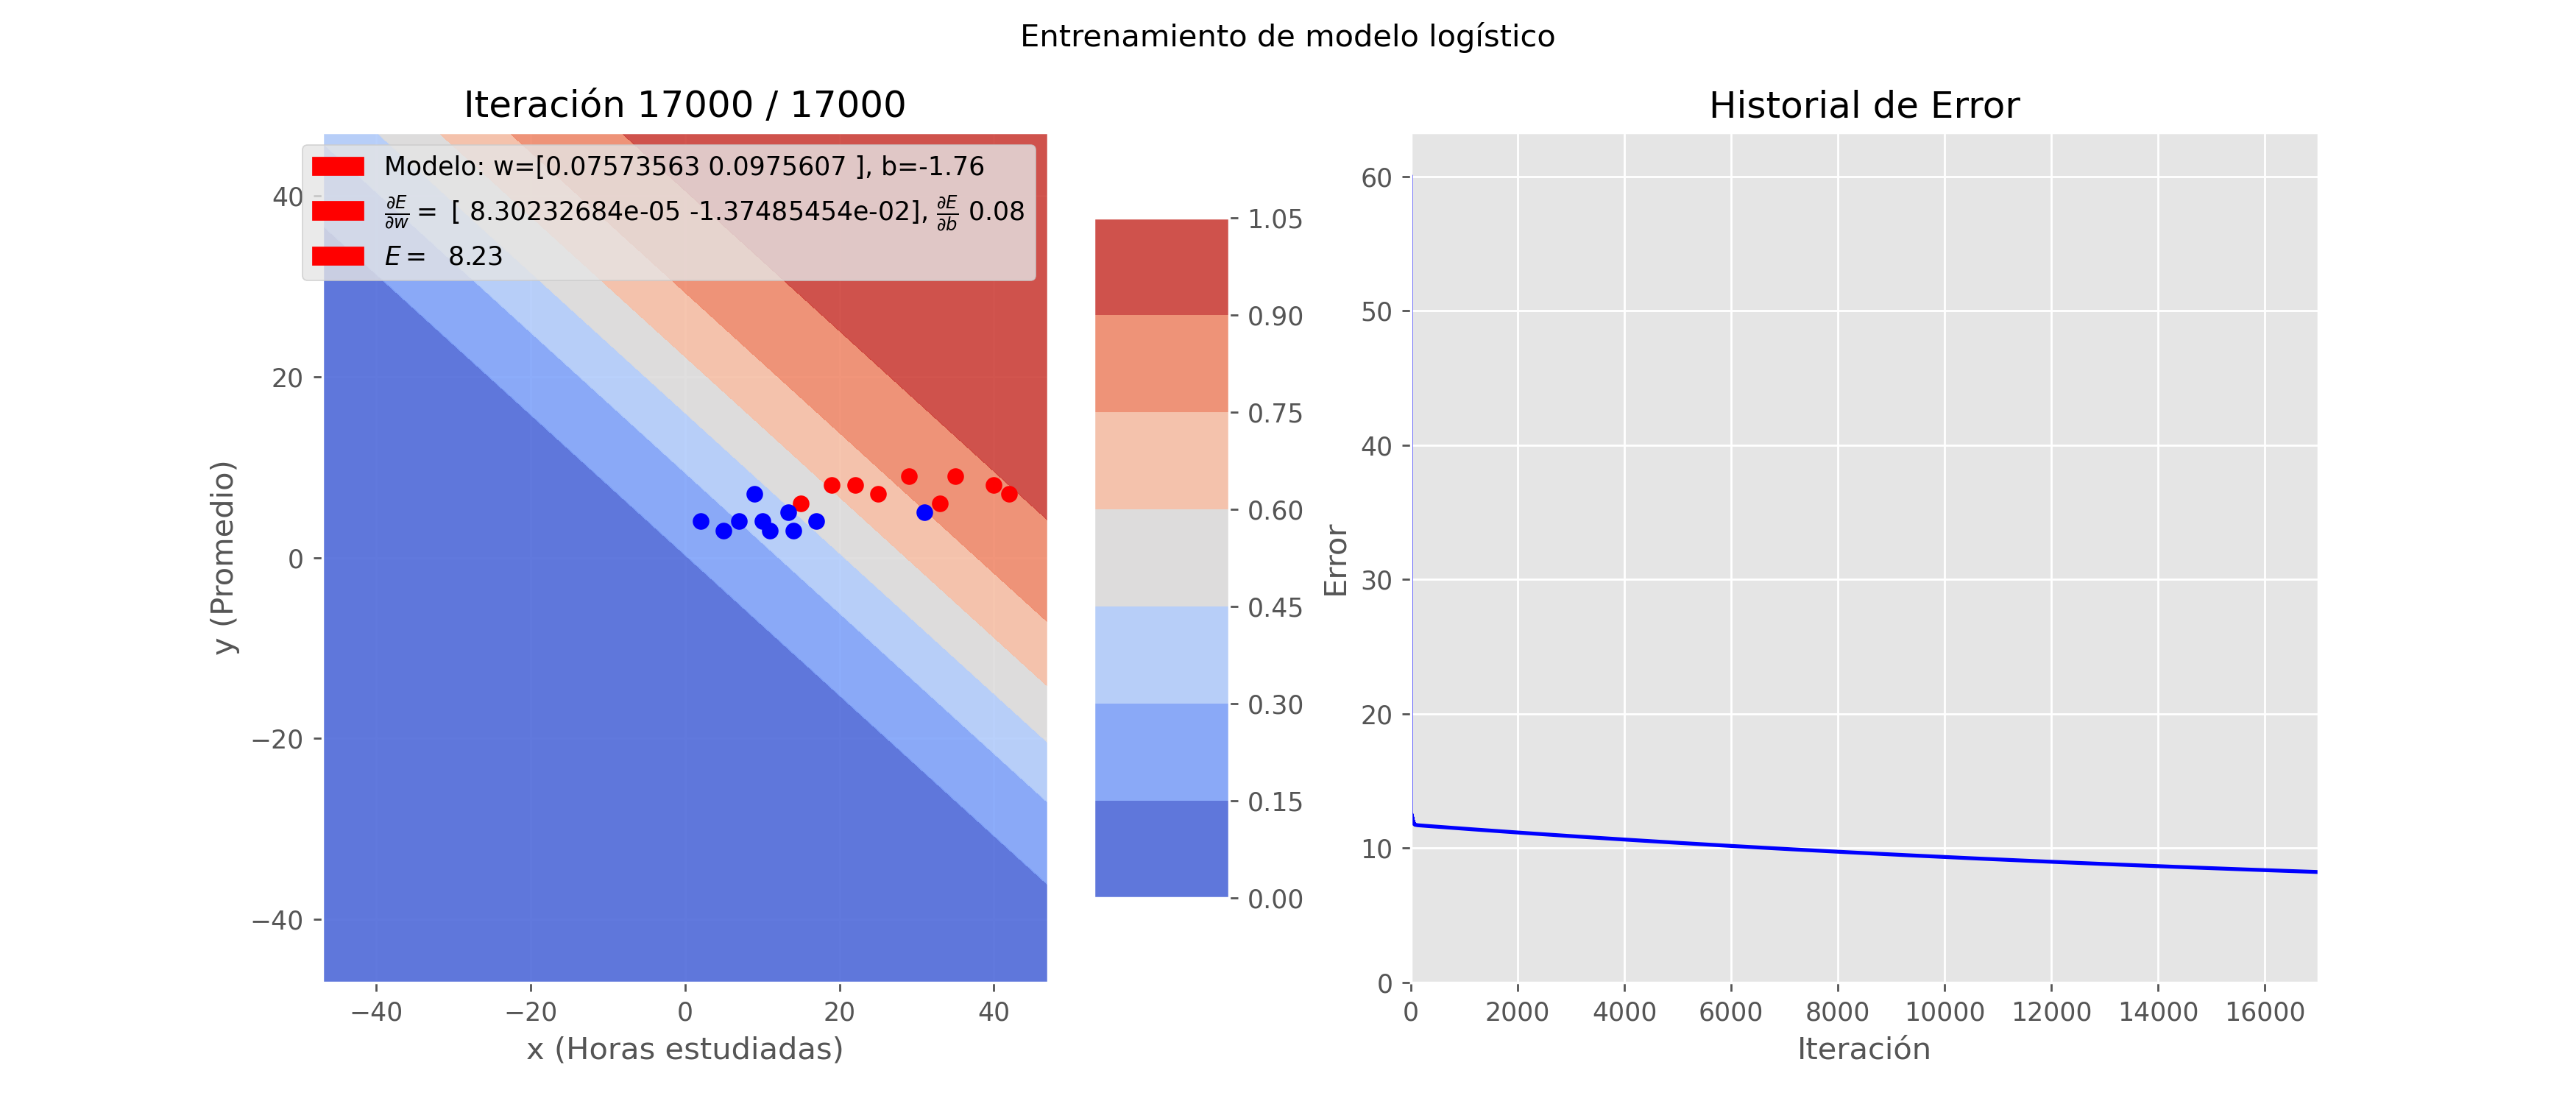

/var/tmp/ipykernel_1244911/533009524.py:104: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(surf, shrink=0.8, aspect=5,ax=ax_data)


In [2]:

## Carga de datos
data=rnutil.load_dataset_numpy("study_logistic_2d.csv")
x,y=data[:,0:2],data[:,2]

## COMIENZO NORMALIZAR
#completar normalizando los vectores x (ambas columnas)

## FIN NORMALIZAR

## Parámetros del modelo (probar valores entre -5 y 5)
w=np.array([-0.2,-0.1])
b=0

# Configuración del descenso de gradiente

#iteraciones máximas a realizar
max_iterations=17000

#velocidad de aprendizaje
#valores sensatos: entre 0.00001 y 0.001
alpha=0.001
#fin Configuración


# Inicialización del algoritmo
iteration=0
mean_error=0
error_history=[]
# Fin inicialización del algoritmo

# Opciones de visualización 
fps=60
#Fin opciones de visualización
plot_state=init_plot(x,y,w,b)
error_history=[]

while iteration<max_iterations:
    
    #DESCENSO DE GRADIENTE
    #predicciones del modelo

    #calculo de derivadas
    dEdw,dEdb=gradient(x,y,w,b)
        
    #CALCULO DE ERROR
    #Calculo del error del modelo
    yhat=predict(x,w,b)
    error = binary_cross_entropy(y,yhat)
    error_history.append(error)
    #FIN CALCULO DE ERROR
    
    #visualización
    if (iteration % 1000 ==0 or iteration == max_iterations-1):
        visualizar(plot_state,x,y,iteration,w,b,dEdw,dEdb,max_iterations,error_history)
        plt.pause(1/fps)
    # fin visualización
    
    #actualizo los parámetros
    w=w-alpha*dEdw
    b=b-alpha*dEdb
    
    # FIN DESCENSO DE GRADIENTE
    iteration+=1
